In [1]:
import tools as tools


from pathlib import Path

# Standard imports 
import numpy as np
import pandas as pd
import geopandas as gpd

# Latex tables
from stargazer.stargazer import Stargazer

# Plotting 
import matplotlib.pyplot as plt 

plt.style.use('seaborn-whitegrid')
%matplotlib inline

import statsmodels.formula.api as smf
from toolz import curry

plt.rcParams['figure.figsize'] = 11, 6 # set default size of plots

# Filter warnings 
pd.options.mode.chained_assignment = None
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

C:\Users\JBH\AppData\Local\Temp\ipykernel_11024\1838888241.py:9: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
C:\Users\JBH\AppData\Local\Temp\ipykernel_11024\1838888241.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped 

**Table of contents**<a id='toc0_'></a>    
- [Data analysis](#toc1_)    
  - [Read web-scraped data](#toc1_1_)    
  - [Convert GPS-coordinates to POINTS](#toc1_2_)    
  - [Read in municipal/regional shape files](#toc1_3_)    
  - [Assign house to old municipality](#toc1_4_)    
  - [Merge landtaxes, house price index, bbr evaluations & lot size info](#toc1_5_)    
  - [Make map of tax changes](#toc1_6_)    
- [How many areas changed land taxes and how many did not?](#toc2_)    
- [Econometrics](#toc3_)    
  - [OLS-FE](#toc3_1_)    
  - [Conditional quantiles, fixed effects equal across quantiles](#toc3_2_)    
    - [Main result of paper](#toc3_2_1_)    
  - [Conditional quantiles, within-quantile fixed effects](#toc3_3_)    
  - [Comparison between cond. quantile, fixed effects across v within](#toc3_4_)    
- [Robustness stuff](#toc4_)    
  - [OLS-FE](#toc4_1_)    
  - [Cond. quantiles](#toc4_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

Header (state non-commercial/academic intentions) for scraper

In [2]:
header = {'name' : 'Jørgen Baun Høst',          'email' : 'pjz633@econ.ku.dk',
          'intention': 'Scrape Boliga for academic purposes'}

# <a id='toc1_'></a>[Data analysis](#toc0_)
## <a id='toc1_1_'></a>[Read web-scraped data](#toc0_)

In [3]:
df=pd.read_parquet('data/boliga.pq')
df=df.sort_values('soldDate')
df['guid']=df['guid'].str.lower()
df['price_1000']=df['price']/1000
df=df[(df['year']>=2000) & (df['year']<=2010)]
df=df.reset_index(drop=True)
df['time_6m']=pd.PeriodIndex(df['soldDate'], freq='2Q')


## <a id='toc1_2_'></a>[Convert GPS-coordinates to POINTS](#toc0_)

In [4]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf.head()

,estateId,address,zipCode,price,soldDate,propertyType,saleType,sqmPrice,rooms,size,...,groupKey,canGetVR,bfEnr,year,month,week,time_q,price_1000,time_6m,geometry
0,0,Højkolvej 36,8210,1495000,2000-01-01 23:00:00+00:00,1,Alm. Salg,8542.8570,4.0,175,...,NaN,True,4220221,2000,1,5,2000Q1,1495.000,2000Q1,POINT (10.16913 56.16901)
1,0,Borthigsgade 26,6000,564680,2000-01-01 23:00:00+00:00,1,Alm. Salg,4826.3247,3.0,117,...,NaN,True,5679177,2000,1,5,2000Q1,564.680,2000Q1,POINT (9.47292 55.48263)
2,0,Horsekilden 17,4000,1251000,2000-01-01 23:00:00+00:00,1,Alm. Salg,10170.7310,4.0,123,...,NaN,True,1304154,2000,1,5,2000Q1,1251.000,2000Q1,POINT (12.02684 55.63139)
3,0,Skovbakkevej 99,8800,370000,2000-01-01 23:00:00+00:00,1,Alm. Salg,2356.6880,6.0,157,...,NaN,True,8459754,2000,1,5,2000Q1,370.000,2000Q1,POINT (9.43825 56.47037)
4,0,Præstebakken 15,2610,1458444,2000-01-01 23:00:00+00:00,1,Alm. Salg,7596.0625,7.0,192,...,NaN,True,2041293,2000,1,5,2000Q1,1458.444,2000Q1,POINT (12.46182 55.67929)


## <a id='toc1_3_'></a>[Read in municipal/regional shape files](#toc0_)

In [5]:
kommune_2006 = gpd.read_file('data/kommune_2006.shp')
kommune_2006.head()

,objectid,navn,enhedid,fra,til,enhedtype,art,SHAPE_Leng,SHAPE_Area,geometry
0,24842.0,Københavns Kommune,120727.0,2002-12-31,2006-12-31,64.0,Kommune,154225.005507,9.028113e+07,"MULTIPOLYGON Z (((12.73424 55.70328 0.00000, 1..."
1,24843.0,Frederiksberg Kommune,120728.0,1970-04-01,2006-12-31,64.0,Kommune,13520.324243,8.709197e+06,"POLYGON Z ((12.53736 55.69661 0.00000, 12.5370..."
2,46149.0,Birkerød Kommune,120748.0,1974-01-04,2006-12-31,64.0,Kommune,35777.227097,3.366869e+07,"POLYGON Z ((12.45040 55.81888 0.00000, 12.4473..."
3,46165.0,Græsted-Gilleleje Kommune,120753.0,1972-10-01,2006-12-31,64.0,Kommune,67562.933801,1.341441e+08,"POLYGON Z ((12.39490 56.03226 0.00000, 12.3952..."
4,46190.0,Jægerspris Kommune,120759.0,1975-01-01,2006-12-31,64.0,Kommune,84485.880031,9.514108e+07,"MULTIPOLYGON Z (((11.92257 55.90000 0.00000, 1..."


In [6]:
regioner=gpd.read_file('data/regioner.shp')
regioner

,objectid,navn,enhedid,fra,til,enhedtype,art,SHAPE_Leng,SHAPE_Area,geometry
0,105612.0,Region Hovedstaden,118711.0,2007-01-01,9999-12-31,66.0,Region,7.371152e+05,2.563160e+09,"MULTIPOLYGON Z (((15.19733 55.31846 0.00000, 1..."
1,105615.0,Region Sjælland,118712.0,2011-11-27,9999-12-31,66.0,Region,2.196684e+06,7.216493e+09,"MULTIPOLYGON Z (((12.54857 54.95316 0.00000, 1..."
2,105616.0,Region Syddanmark,118713.0,2007-01-01,9999-12-31,66.0,Region,2.436420e+06,1.209603e+10,"MULTIPOLYGON Z (((10.68129 54.72772 0.00000, 1..."
3,105620.0,Region Midtjylland,118715.0,2011-01-01,9999-12-31,66.0,Region,2.564054e+06,1.299856e+10,"MULTIPOLYGON Z (((11.67150 56.73861 0.00000, 1..."
4,105617.0,Region Nordjylland,118714.0,2007-01-01,9999-12-31,66.0,Region,1.697705e+06,7.870127e+09,"MULTIPOLYGON Z (((10.98412 57.21880 0.00000, 1..."


## <a id='toc1_4_'></a>[Assign house to old municipality](#toc0_)

In [7]:
gdf_merge=gpd.sjoin(gdf, kommune_2006, predicate='within')
cols_to_drop=['index_right',
 'objectid',
 'navn',
 'enhedid',
 'fra',
 'til',
 'enhedtype',
 'art',
 'SHAPE_Leng',
 'SHAPE_Area']
gdf_merge['kommune_old']=gdf_merge['navn']
gdf_merge=gdf_merge.drop(columns=cols_to_drop)
gdf_merge=gpd.sjoin(gdf_merge, regioner, predicate='within')
gdf_merge['region']=gdf_merge['navn']
gdf_merge=gdf_merge.drop(columns=cols_to_drop)
gdf_merge.head()

C:\Users\JBH\AppData\Local\Temp\ipykernel_11024\118371585.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf_merge=gpd.sjoin(gdf, kommune_2006, predicate='within')
C:\Users\JBH\AppData\Local\Temp\ipykernel_11024\118371585.py:14: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf_merge=gpd.sjoin(gdf_merge, regioner, predicate='within')


,estateId,address,zipCode,price,soldDate,propertyType,saleType,sqmPrice,rooms,size,...,bfEnr,year,month,week,time_q,price_1000,time_6m,geometry,kommune_old,region
0,0,Højkolvej 36,8210,1495000,2000-01-01 23:00:00+00:00,1,Alm. Salg,8542.8570,4.0,175,...,4220221,2000,1,5,2000Q1,1495.00,2000Q1,POINT (10.16913 56.16901),Århus Kommune,Region Midtjylland
23,0,Byløkken 32,8240,1887740,2000-01-01 23:00:00+00:00,1,Alm. Salg,10372.1980,6.0,182,...,4230330,2000,1,5,2000Q1,1887.74,2000Q1,POINT (10.22040 56.20569),Århus Kommune,Region Midtjylland
32,0,Gertrud Rasks Vej 2,8200,1576500,2000-01-02 23:00:00+00:00,1,Alm. Salg,9219.2980,6.0,171,...,5629660,2000,1,6,2000Q1,1576.50,2000Q1,POINT (10.21504 56.17655),Århus Kommune,Region Midtjylland
39,0,Bjørnshøjvej 2K,8380,875000,2000-01-02 23:00:00+00:00,1,Alm. Salg,7812.5000,4.0,112,...,4209569,2000,1,6,2000Q1,875.00,2000Q1,POINT (10.15009 56.25355),Århus Kommune,Region Midtjylland
42,0,Skæring Havvej 31,8250,1566000,2000-01-02 23:00:00+00:00,1,Alm. Salg,7492.8228,6.0,209,...,4144887,2000,1,6,2000Q1,1566.00,2000Q1,POINT (10.30097 56.23074),Århus Kommune,Region Midtjylland


In [8]:
house_price_index = pd.read_excel('data/house_price_index.xlsx')
house_price_index['time_q']=pd.PeriodIndex(house_price_index['time_q'], freq='Q')
land_taxes = pd.read_excel('data/kmn_grundskyldspromille.xlsx', sheet_name='Sheet2')
property_evals_01=pd.read_parquet('data/bbr_eval2001.pq')
property_evals_07=pd.read_parquet('data/bbr_eval2007.pq')
lot_sizes = pd.read_parquet('data/bbr_lotsize.pq')

## <a id='toc1_5_'></a>[Merge landtaxes, house price index, bbr evaluations & lot size info](#toc0_)

In [9]:
df_merged = pd.DataFrame(gdf_merge)
df_merged_index = pd.merge(df_merged, house_price_index, left_on=['time_q', 'region'], right_on=['time_q', 'region'])
df_merged_index = pd.merge(df_merged_index, land_taxes, left_on=['kommune_old'], right_on=['kommune_old'])
df_merged_index = pd.merge(df_merged_index, property_evals_01, left_on=['guid'], right_on=['guid'])
df_merged_index=df_merged_index.drop(columns=['eval_year'])
df_merged_index = pd.merge(df_merged_index, property_evals_07, left_on=['guid'], right_on=['guid'])
df_merged_index=df_merged_index.drop(columns=['eval_year'])
df_merged_index = pd.merge(df_merged_index, lot_sizes, left_on=['guid'], right_on=['guid'])
df_merged_index

,estateId,address,zipCode,price,soldDate,propertyType,saleType,sqmPrice,rooms,size,...,kommune_grundskyld2007,delta_tax,delta_tax_service,eval_prop_2001,eval_land_2001,eval2001_last_changed,eval_prop_2007,eval_land_2007,eval2007_last_changed,lot_size
0,0,Højkolvej 36,8210,1495000,2000-01-01 23:00:00+00:00,1,Alm. Salg,8542.8570,4.0,175,...,"24,58",-0.02,0.10,1600000,393500,2001-01-01,3000000,787000,2007-10-01,774
1,0,Højkolvej 36,8210,2770000,2006-05-23 22:00:00+00:00,1,Alm. Salg,15828.5710,4.0,175,...,"24,58",-0.02,0.10,1600000,393500,2001-01-01,3000000,787000,2007-10-01,774
2,0,Byløkken 32,8240,1887740,2000-01-01 23:00:00+00:00,1,Alm. Salg,10372.1980,6.0,182,...,"24,58",-0.02,0.10,1700000,364700,2001-01-01,3550000,1296800,2007-10-01,821
3,0,Gertrud Rasks Vej 2,8200,1576500,2000-01-02 23:00:00+00:00,1,Alm. Salg,9219.2980,6.0,171,...,"24,58",-0.02,0.10,1800000,466900,2001-01-01,3850000,1127000,2007-10-01,810
4,0,Bjørnshøjvej 2K,8380,875000,2000-01-02 23:00:00+00:00,1,Alm. Salg,7812.5000,4.0,112,...,"24,58",-0.02,0.10,870000,252600,2001-01-01,1800000,631500,2007-10-01,884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482047,508367,Danzigmannvej 3,9940,1075000,2010-07-29 22:00:00+00:00,1,Alm. Salg,10858.5860,5.0,99,...,"33,04",-0.96,-0.77,340000,62700,2001-01-01,510000,150700,2007-10-01,2500
482048,0,"Vesterø Havnegade 12, 1",9940,1500000,2010-07-31 22:00:00+00:00,1,Alm. Salg,15625.0000,3.0,96,...,"33,04",-0.96,-0.77,360000,69500,2001-01-01,900000,249400,2007-10-01,910
482049,459987,Byrumvej 45,9940,295000,2010-08-26 22:00:00+00:00,1,Alm. Salg,2107.1428,6.0,98,...,"33,04",-0.96,-0.77,320000,45100,2001-01-01,490000,117300,2007-10-01,1005
482050,435189,Gammel Østerbyvej 20,9940,498000,2010-09-01 22:00:00+00:00,1,Alm. Salg,3458.3333,4.0,144,...,"33,04",-0.96,-0.77,490000,41800,2001-01-01,770000,108600,2007-10-01,870


Keeping non-zero observations

In [10]:
df_merged_index=df_merged_index[df_merged_index['lot_size']!=0]
df_merged_index=df_merged_index[df_merged_index['eval_prop_2001']!=0]
df_merged_index=df_merged_index[df_merged_index['eval_prop_2007']!=0]
df_merged_index

,estateId,address,zipCode,price,soldDate,propertyType,saleType,sqmPrice,rooms,size,...,kommune_grundskyld2007,delta_tax,delta_tax_service,eval_prop_2001,eval_land_2001,eval2001_last_changed,eval_prop_2007,eval_land_2007,eval2007_last_changed,lot_size
0,0,Højkolvej 36,8210,1495000,2000-01-01 23:00:00+00:00,1,Alm. Salg,8542.8570,4.0,175,...,"24,58",-0.02,0.10,1600000,393500,2001-01-01,3000000,787000,2007-10-01,774
1,0,Højkolvej 36,8210,2770000,2006-05-23 22:00:00+00:00,1,Alm. Salg,15828.5710,4.0,175,...,"24,58",-0.02,0.10,1600000,393500,2001-01-01,3000000,787000,2007-10-01,774
2,0,Byløkken 32,8240,1887740,2000-01-01 23:00:00+00:00,1,Alm. Salg,10372.1980,6.0,182,...,"24,58",-0.02,0.10,1700000,364700,2001-01-01,3550000,1296800,2007-10-01,821
3,0,Gertrud Rasks Vej 2,8200,1576500,2000-01-02 23:00:00+00:00,1,Alm. Salg,9219.2980,6.0,171,...,"24,58",-0.02,0.10,1800000,466900,2001-01-01,3850000,1127000,2007-10-01,810
4,0,Bjørnshøjvej 2K,8380,875000,2000-01-02 23:00:00+00:00,1,Alm. Salg,7812.5000,4.0,112,...,"24,58",-0.02,0.10,870000,252600,2001-01-01,1800000,631500,2007-10-01,884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482047,508367,Danzigmannvej 3,9940,1075000,2010-07-29 22:00:00+00:00,1,Alm. Salg,10858.5860,5.0,99,...,"33,04",-0.96,-0.77,340000,62700,2001-01-01,510000,150700,2007-10-01,2500
482048,0,"Vesterø Havnegade 12, 1",9940,1500000,2010-07-31 22:00:00+00:00,1,Alm. Salg,15625.0000,3.0,96,...,"33,04",-0.96,-0.77,360000,69500,2001-01-01,900000,249400,2007-10-01,910
482049,459987,Byrumvej 45,9940,295000,2010-08-26 22:00:00+00:00,1,Alm. Salg,2107.1428,6.0,98,...,"33,04",-0.96,-0.77,320000,45100,2001-01-01,490000,117300,2007-10-01,1005
482050,435189,Gammel Østerbyvej 20,9940,498000,2010-09-01 22:00:00+00:00,1,Alm. Salg,3458.3333,4.0,144,...,"33,04",-0.96,-0.77,490000,41800,2001-01-01,770000,108600,2007-10-01,870


## <a id='toc1_6_'></a>[Make map of tax changes](#toc0_)
Merge land tax info

In [11]:
kommune_2006=kommune_2006.rename(columns={'navn': 'kommune_old'})

In [12]:
kommune_2006=kommune_2006.merge(land_taxes, on='kommune_old')

In [13]:
from matplotlib import colors
mycmap = colors.ListedColormap(['midnightblue','mediumblue','blue','cyan','red','orangered','darkred'])
norm = colors.Normalize(kommune_2006.delta_tax.min(), kommune_2006.delta_tax.max())

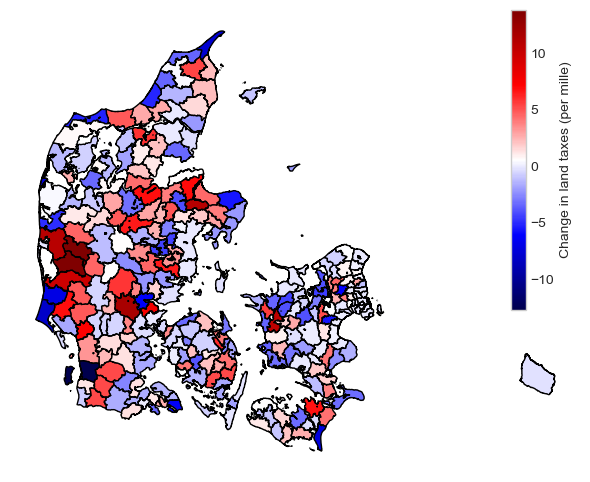

In [14]:
fig, ax = plt.subplots(1, 1)
kommune_2006.plot(column='delta_tax',
           ax=ax,
           cmap='seismic',
           norm=norm,
           legend=True,
           legend_kwds={'label': "Change in land taxes (per mille)",
                        'orientation': "vertical",
                        "shrink":.65,
                        'anchor': (-1, 1)},
            edgecolor='k')
ax.set_axis_off()   
fig.savefig('figs/fig_map_taxes.pdf', bbox_inches = "tight")

Adding important variables

In [15]:
df_merged_index['real_price']=df_merged_index['price']/df_merged_index['house_price_index']
df_merged_index['real_sqmPrice']=df_merged_index['sqmPrice']/df_merged_index['house_price_index']
df_merged_index['ln_prop_value']=np.log(df_merged_index['eval_prop_2001'])
df_merged_index['ln_price']=np.log(df_merged_index['price'])
df_merged_index['ln_real_price']=np.log(df_merged_index['real_price'])
df_merged_index['delta_tax_eff']=(df_merged_index['delta_tax']*df_merged_index['eval_land_2007']/df_merged_index['eval_prop_2007'])
df_merged_index['delta_tax_service']

0         0.10
1         0.10
2         0.10
3         0.10
4         0.10
          ... 
482047   -0.77
482048   -0.77
482049   -0.77
482050   -0.77
482051   -0.77
Name: delta_tax_service, Length: 480638, dtype: float64

Categorize data by changes to land taxes

In [16]:
def land_tax_change07(value):
    if value > 0:
        return "Higher"
    elif value < 0:
        return "Lower"
    else:
        return "Unchanged"
df_merged_index['tax_change_reform'] = df_merged_index.apply(lambda row: land_tax_change07(row['delta_tax']), axis = 1)
df_merged_index['tax_change_reform']=df_merged_index['tax_change_reform'].astype('category')

# <a id='toc2_'></a>[How many areas changed land taxes and how many did not?](#toc0_)

In [17]:
df_merged_index.groupby('tax_change_reform')['kommune_old'].nunique()

tax_change_reform
Higher       132
Lower        110
Unchanged     24
Name: kommune_old, dtype: int64

In [18]:
df_merged_index.groupby('tax_change_reform')[['kommune_old', 'delta_tax']].max()

,kommune_old,delta_tax
tax_change_reform,,
Higher,Ørbæk Kommune,13.86
Lower,Ærø Kommune,-0.02
Unchanged,Værløse Kommune,0.00


In [19]:
df_merged_index.groupby('tax_change_reform')[['kommune_old', 'delta_tax']].max()

,kommune_old,delta_tax
tax_change_reform,,
Higher,Ørbæk Kommune,13.86
Lower,Ærø Kommune,-0.02
Unchanged,Værløse Kommune,0.00


In [20]:
df_merged_index.groupby('tax_change_reform')[['kommune_old', 'delta_tax']].min()

,kommune_old,delta_tax
tax_change_reform,,
Higher,Allerød Kommune,0.02
Lower,Augustenborg Kommune,-12.76
Unchanged,Brøndbyøster-Brøndbyvester Kommune,0.00


In [21]:
df_merged_index[df_merged_index['year']>=2007].groupby('tax_change_reform')[['kommune_old', 'delta_tax_eff']].mean()

C:\Users\JBH\AppData\Local\Temp\ipykernel_11024\2888431242.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_merged_index[df_merged_index['year']>=2007].groupby('tax_change_reform')[['kommune_old', 'delta_tax_eff']].mean()


,delta_tax_eff
tax_change_reform,
Higher,0.670389
Lower,-0.453174
Unchanged,0.000000


In [22]:
df_merged_index[df_merged_index['year']>=2007].groupby('tax_change_reform')[['kommune_old', 'delta_tax_eff']].std()

C:\Users\JBH\AppData\Local\Temp\ipykernel_11024\491435750.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_merged_index[df_merged_index['year']>=2007].groupby('tax_change_reform')[['kommune_old', 'delta_tax_eff']].std()


,delta_tax_eff
tax_change_reform,
Higher,0.734330
Lower,0.524529
Unchanged,0.000000


In [23]:
df_merged_index.columns

Index(['estateId', 'address', 'zipCode', 'price', 'soldDate', 'propertyType',
       'saleType', 'sqmPrice', 'rooms', 'size', 'buildYear', 'guid',
       'latitude', 'longitude', 'municipalityCode', 'estateCode', 'city',
       'groupKey', 'canGetVR', 'bfEnr', 'year', 'month', 'week', 'time_q',
       'price_1000', 'time_6m', 'geometry', 'kommune_old', 'region',
       'house_price_index', 'kommune_amt_2006', 'kommune_sund_2007',
       'kommune_grundskyld2006', 'kommune_grundskyld2007', 'delta_tax',
       'delta_tax_service', 'eval_prop_2001', 'eval_land_2001',
       'eval2001_last_changed', 'eval_prop_2007', 'eval_land_2007',
       'eval2007_last_changed', 'lot_size', 'real_price', 'real_sqmPrice',
       'ln_prop_value', 'ln_price', 'ln_real_price', 'delta_tax_eff',
       'tax_change_reform'],
      dtype='object')

In [24]:
df_merged_index.groupby('tax_change_reform')[['kommune_old', 'eval_prop_2007']].mean()/1000

C:\Users\JBH\AppData\Local\Temp\ipykernel_11024\4118881633.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_merged_index.groupby('tax_change_reform')[['kommune_old', 'eval_prop_2007']].mean()/1000


,eval_prop_2007
tax_change_reform,
Higher,1794.302509
Lower,1812.015257
Unchanged,3380.962513


In [25]:
df_merged_index.groupby('tax_change_reform')[['kommune_old', 'eval_prop_2007']].std()/1000

C:\Users\JBH\AppData\Local\Temp\ipykernel_11024\4272510388.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_merged_index.groupby('tax_change_reform')[['kommune_old', 'eval_prop_2007']].std()/1000


,eval_prop_2007
tax_change_reform,
Higher,3394.361410
Lower,2816.223155
Unchanged,2962.725886


In [26]:
df_merged_index[df_merged_index['year']>=2007]['delta_tax_eff'].mean()

0.060088384318130746

In [27]:
df_merged_index[df_merged_index['year']>=2007]['delta_tax_eff'].std()

0.7946022781952236

In [28]:
df_merged_index=df_merged_index[df_merged_index['tax_change_reform']!="Unchanged"]

C:\Users\JBH\AppData\Local\Temp\ipykernel_11024\723349955.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp_agg=df_merged_index.groupby(['year', 'tax_change_reform']).mean()


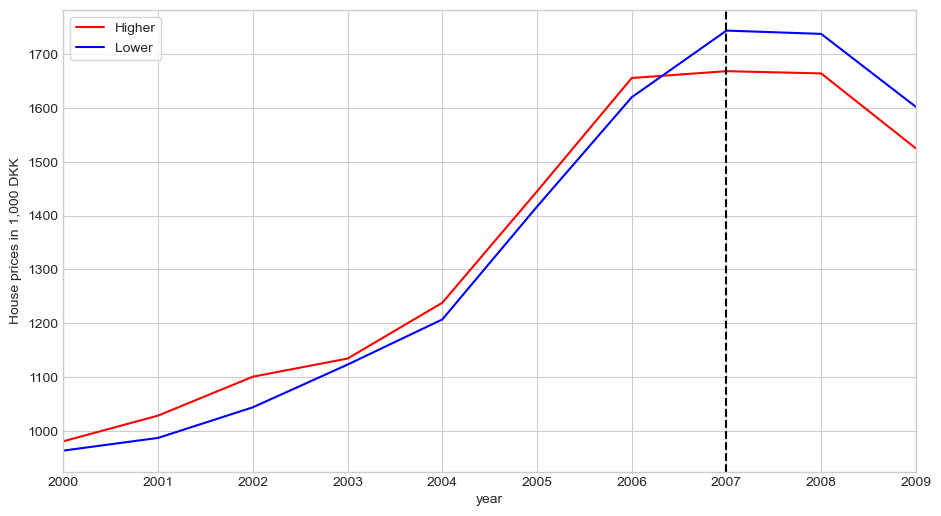

In [29]:
temp_agg=df_merged_index.groupby(['year', 'tax_change_reform']).mean()
temp_agg_high_low = temp_agg.unstack()
plot=temp_agg_high_low['price_1000'][['Higher', 'Lower']].plot(color=['r', 'b'])
plot.axvline(x=2007,color='k', linestyle='--')
plot.set_xlim(2000, 2009)
plot.legend(frameon=True)
plot.set_xticks(np.arange(df_merged_index['year'].min(), df_merged_index['year'].max(), 1))
plt.ylabel('House prices in 1,000 DKK')

plt.savefig('figs/fig_house_price_trends.pdf', bbox_inches='tight')

In [30]:
df_merged_index=df_merged_index[df_merged_index['year']<=2008]
df_merged_index = df_merged_index.reset_index(drop=True)

In [31]:
stata_out = df_merged_index[['guid','ln_price', 'ln_real_price', 'kommune_old', 'year', 'ln_prop_value', 'delta_tax_eff']]
stata_out['kommune_old_id']=stata_out.groupby('kommune_old').ngroup()
stata_out['id']=stata_out.groupby('guid').ngroup()
stata_out.to_stata('data/house.dta')

# <a id='toc3_'></a>[Econometrics](#toc0_)
Function to demean

In [32]:
@curry
def demean(df, col_to_demean):
    return df.assign(**{col_to_demean: (df[col_to_demean]
                                        - df.groupby("kommune_old")[col_to_demean].transform("mean"))
                                        - df.groupby("year")[col_to_demean].transform("mean")})

Create variables that capture (potentially gradual) effect of changes to effect land value taxes following the 2007 reform

In [33]:
years = [2004, 2005, 2006, 2007, 2008]


for year in years:
    var_name = f'year{year}_delta_tax_eff'
    df_merged_index[var_name]=(df_merged_index['year']==year).astype(int)*df_merged_index['delta_tax_eff']
    var_name2 = f'year{year}_delta_tax_service'
    df_merged_index[var_name2]=(df_merged_index['year']==year).astype(int)*df_merged_index['delta_tax_service']

## <a id='toc3_1_'></a>[OLS-FE](#toc0_)

In [34]:
formula = f"""ln_real_price ~ year2005_delta_tax_eff + year2006_delta_tax_eff + year2007_delta_tax_eff + year2008_delta_tax_eff + ln_prop_value"""

mod_ols_fe = smf.ols(formula,
              data=df_merged_index
              .pipe(demean(col_to_demean="ln_real_price"))
              .pipe(demean(col_to_demean="year2005_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2006_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2007_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2008_delta_tax_eff"))
              .pipe(demean(col_to_demean="ln_prop_value")))
res_ols_fe=mod_ols_fe.fit(cov_type='cluster', cov_kwds={'groups': df_merged_index['kommune_old']}, fe=True)
res_ols_fe.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ln_real_price   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     1242.
Date:                Mon, 01 May 2023   Prob (F-statistic):          9.08e-170
Time:                        15:50:40   Log-Likelihood:            -2.3927e+05
No. Observations:              374895   AIC:                         4.785e+05
Df Residuals:                  374889   BIC:                         4.786e+05
Df Model:                           5                                         
Covariance Type:              cluster                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -4.8339      0.118    -41.133      0.000      -5.064      -4.604
year2005_delta_tax_eff    -0.0142      0.006     -2.578      0.010      -0.025      -0.003
year2006_delta_tax_eff    -0.0254      0.007     -3.726      0.000      -0.039      -0.012
year2007_delta_tax_eff    -0.0302      0.008     -3.899      0.000      -0.045      -0.015
year2008_delta_tax_eff    -0.0155      0.006     -2.524      0.012      -0.027      -0.003
ln_prop_value              0.6797      0.009     78.628      0.000       0.663       0.697
==============================================================================
Omnibus:                   223912.018   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8296715.282
Skew:                          -2.293   Prob(JB):                         0.00
Kurtosis:                      25.586   Cond. No.                         364.
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

## <a id='toc3_2_'></a>[Conditional quantiles, fixed effects equal across quantiles](#toc0_)

In [35]:
mod_quantile_fe_across = smf.quantreg(formula,
              data=df_merged_index
              .pipe(demean(col_to_demean="ln_real_price"))
              .pipe(demean(col_to_demean="year2005_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2006_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2007_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2008_delta_tax_eff"))
              .pipe(demean(col_to_demean="ln_prop_value")))
result_quantile=mod_quantile_fe_across.fit(q=0.5,cov_type='cluster', cov_kwds={'groups': df_merged_index['kommune_old']})
result_quantile.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:          ln_real_price   Pseudo R-squared:               0.3374
Model:                       QuantReg   Bandwidth:                     0.01475
Method:                 Least Squares   Sparsity:                       0.5108
Date:                Mon, 01 May 2023   No. Observations:               374895
Time:                        15:50:45   Df Residuals:                   374889
                                        Df Model:                            5
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -2.2410      0.011   -202.041      0.000      -2.263      -2.219
year2005_delta_tax_eff    -0.0185      0.002    -11.975      0.000      -0.021      -0.015
year2006_delta_tax_eff    -0.0238      0.002    -14.759      0.000      -0.027      -0.021
year2007_delta_tax_eff    -0.0274      0.002    -17.040      0.000      -0.031      -0.024
year2008_delta_tax_eff    -0.0193      0.002    -10.540      0.000      -0.023      -0.016
ln_prop_value              0.8680      0.001   1064.610      0.000       0.866       0.870
==========================================================================================
"""

In [36]:
quantiles = np.arange(0.1, 0.9+0.1, 0.1)


def fit_model(q, sig_level=0.05):
    result_quantile = mod_quantile_fe_across.fit(q=q, cov_type='cluster', cov_kwds={'groups': df_merged_index['kommune_old']})
    return [q, result_quantile.params["year2007_delta_tax_eff"]] + result_quantile.conf_int(alpha=sig_level).loc[
        "year2007_delta_tax_eff"
    ].tolist()


models_fe_across = [fit_model(x) for x in quantiles]
models_fe_across = pd.DataFrame(models_fe_across, columns=["q", "year2007_delta_tax_eff", "lb", "ub"])

In [37]:
models_fe_across

,q,year2007_delta_tax_eff,lb,ub
0,0.1,-0.017370,-0.032008,-0.002733
1,0.2,-0.021771,-0.027297,-0.016245
2,0.3,-0.024197,-0.028006,-0.020389
3,0.4,-0.025889,-0.029184,-0.022593
4,0.5,-0.027360,-0.030507,-0.024213
5,0.6,-0.028673,-0.031928,-0.025417
6,0.7,-0.029389,-0.033131,-0.025647
7,0.8,-0.030794,-0.035701,-0.025886
8,0.9,-0.039954,-0.048610,-0.031297


In [38]:
ols_fe_ci = res_ols_fe.conf_int(alpha=0.1).loc['year2007_delta_tax_eff'].to_list()
ols_fe_ci

[-0.042935700587221515, -0.017457584810956408]

In [39]:
ols_fe_dict=dict(param=res_ols_fe.params['year2007_delta_tax_eff'], lb=ols_fe_ci[0], ub=ols_fe_ci[1])
ols_fe_dict

{'param': -0.03019664269908896,
 'lb': -0.042935700587221515,
 'ub': -0.017457584810956408}

### <a id='toc3_2_1_'></a>[Main result of paper](#toc0_)

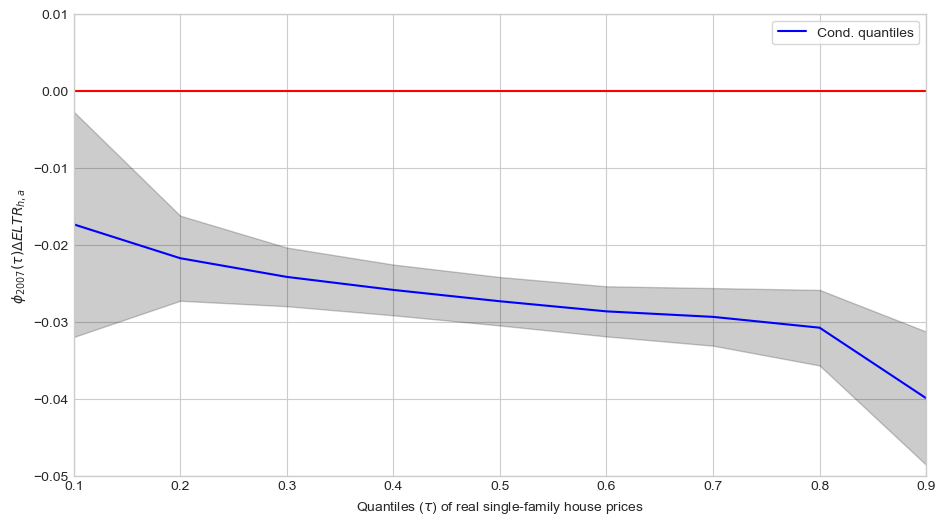

In [40]:
param_name = r'$\phi_{2007}(\tau) \Delta E L T R_{h, a}$'

n = models_fe_across.shape[0]
p1 = plt.plot(models_fe_across.q, models_fe_across.year2007_delta_tax_eff, color="blue", label="Cond. quantiles")
plt.fill_between(models_fe_across.q, models_fe_across.ub, models_fe_across.lb, alpha=0.2, color="black")
# p4 = plt.plot(models_fe_across.q, [ols_fe_dict["param"]] * n, color="black", linestyle='--',label="OLS-FE")
# plt.fill_between(models_fe_across.q, ols_fe_dict["lb"], ols_fe_dict["ub"], alpha=0.2, color="black")
plt.ylabel(param_name)
plt.xlabel(r"Quantiles ($\tau$) of real single-family house prices")
plt.axhline(0, color='red')
plt.xlim(0.1, 0.9)
plt.ylim(-0.05, 0.01)
plt.legend(frameon=True)
plt.savefig('figs/fig_quant_reg_res.pdf', bbox_inches='tight')
plt.savefig('figs/fig_quant_reg_res.png', bbox_inches='tight')
plt.show()

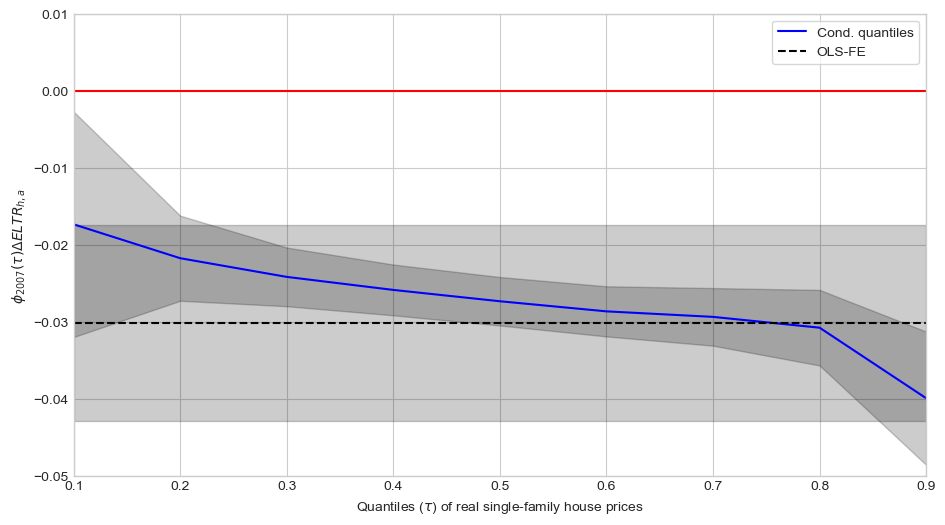

In [62]:
param_name = r'$\phi_{2007}(\tau) \Delta E L T R_{h, a}$'



n = models_fe_across.shape[0]
p1 = plt.plot(models_fe_across.q, models_fe_across.year2007_delta_tax_eff, color="blue", label="Cond. quantiles")
plt.fill_between(models_fe_across.q, models_fe_across.ub, models_fe_across.lb, alpha=0.2, color="black")
p4 = plt.plot(models_fe_across.q, [ols_fe_dict["param"]] * n, color="black", linestyle='--',label="OLS-FE")
plt.fill_between(models_fe_across.q, ols_fe_dict["lb"], ols_fe_dict["ub"], alpha=0.2, color="black")
plt.ylabel(param_name)
plt.xlabel(r"Quantiles ($\tau$) of real single-family house prices")
plt.axhline(0, color='red')
plt.xlim(0.1, 0.9)
plt.ylim(-0.05, 0.01)
plt.legend(frameon=True, loc='upper right')
plt.savefig('figs/fig_quant_v_ols.pdf', bbox_inches='tight')
plt.show()

## <a id='toc3_3_'></a>[Conditional quantiles, within-quantile fixed effects](#toc0_)
NB! Requires Stata 17 or higher, see [pystata](https://www.stata.com/python/pystata18/notebook/Quick%20Start0.html)

In [50]:
import stata_setup

path_to_stata = "C:/Program Files/Stata17"
stata_version = 'mp'

stata_setup.config(path_to_stata, stata_version)

In [51]:
%%stata

do "qreg.do"


. 
. do "qreg.do"

. use "data\house.dta", clear

. gen year05 = 1 if year == 2005
(326,252 missing values generated)

. replace year05 = 0 if year != 2005
(326,252 real changes made)

. gen year06 = 1 if year == 2006
(332,244 missing values generated)

. replace year06 = 0 if year!= 2006
(332,244 real changes made)

. gen year07 = 1 if year == 2007
(334,064 missing values generated)

. replace year07 = 0 if year != 2007
(334,064 real changes made)

. gen year08 = 1 if year == 2008
(344,452 missing values generated)

. replace year08 = 0 if year != 2008
(344,452 real changes made)

. gen year05_delta_tax_eff = year05*delta_tax_eff 

. gen year06_delta_tax_eff = year06*delta_tax_eff 

. gen year07_delta_tax_eff = year07*delta_tax_eff 

. gen year08_delta_tax_eff = year08*delta_tax_eff 

. 
. forvalues i = 10(10)90 {
  2.         preserve
  3.         eststo quant_est_`i': mmqreg  ln_real_price year05_delta_tax_eff y
> ear06_delta_tax_eff year07_delta_tax_eff year08_delta_tax_eff ln_pro

In [66]:
list_of_dfs = []

for quant in range(10, 90+10, 10):
    df = pd.read_stata(f'models/quant_est_{quant}.dta')
    list_of_dfs.append(df)

quantiles_within_fe = pd.concat(list_of_dfs).reset_index(drop=True) 
quantiles_within_fe

,q,b,se,z,pvalue,ll,ul,df,crit,eform,varname
0,0.1,-0.010096,0.006058,-1.666663,9.558139e-02,-0.021969,0.001777,NaN,1.959964,0.0,year07_delta_tax_eff
1,0.2,-0.020456,0.004324,-4.730875,2.235548e-06,-0.028931,-0.011981,NaN,1.959964,0.0,year07_delta_tax_eff
2,0.3,-0.025426,0.003622,-7.020128,2.216652e-12,-0.032525,-0.018327,NaN,1.959964,0.0,year07_delta_tax_eff
3,0.4,-0.028931,0.003221,-8.982686,2.642360e-19,-0.035244,-0.022619,NaN,1.959964,0.0,year07_delta_tax_eff
4,0.5,-0.031912,0.002969,-10.748560,6.019420e-27,-0.037731,-0.026093,NaN,1.959964,0.0,year07_delta_tax_eff
5,0.6,-0.034734,0.002828,-12.284137,1.102151e-34,-0.040276,-0.029192,NaN,1.959964,0.0,year07_delta_tax_eff
6,0.7,-0.037701,0.002797,-13.480440,0.000000e+00,-0.043183,-0.032220,NaN,1.959964,0.0,year07_delta_tax_eff
7,0.8,-0.041406,0.002932,-14.122587,0.000000e+00,-0.047152,-0.035659,NaN,1.959964,0.0,year07_delta_tax_eff
8,0.9,-0.047614,0.003516,-13.543161,0.000000e+00,-0.054504,-0.040723,NaN,1.959964,0.0,year07_delta_tax_eff


## <a id='toc3_4_'></a>[Comparison between cond. quantile, fixed effects across v within](#toc0_)

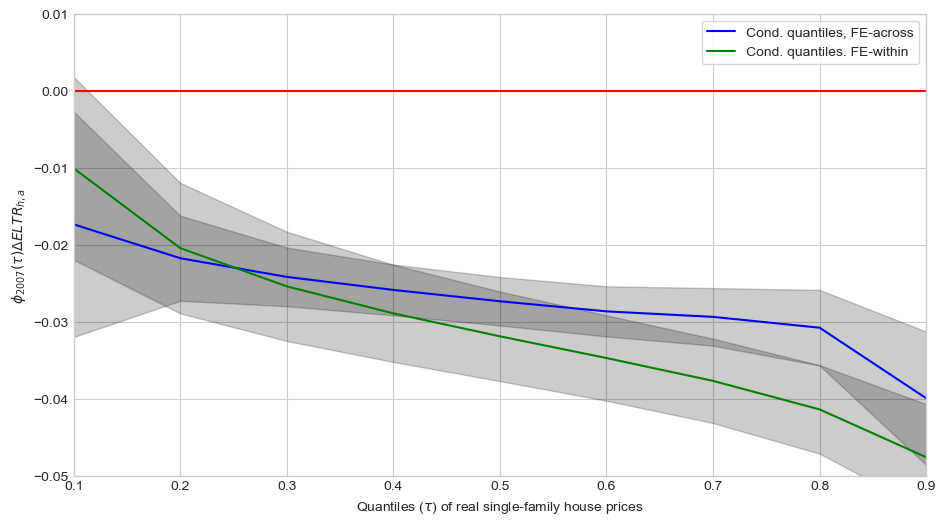

In [64]:
param_name = r'$\phi_{2007}(\tau) \Delta E L T R_{h, a}$'

n = models_fe_across.shape[0]
plt.plot(models_fe_across.q, models_fe_across.year2007_delta_tax_eff, color="blue", label="Cond. quantiles, FE-across")
plt.fill_between(models_fe_across.q, models_fe_across.ub, models_fe_across.lb, alpha=0.2, color="black")
plt.plot(quantiles_within_fe.q, quantiles_within_fe.b, color="green", label="Cond. quantiles. FE-within")
plt.fill_between(quantiles_within_fe.q, quantiles_within_fe.ul, quantiles_within_fe.ll, alpha=0.2, color="black")
plt.ylabel(param_name)
plt.xlabel(r"Quantiles ($\tau$) of real single-family house prices")
plt.axhline(0, color='red')
plt.xlim(0.1, 0.9)
plt.ylim(-0.05, 0.01)
plt.legend(frameon=True)
plt.savefig('figs/fig_quant_reg_res_fe_within_v_across.pdf', bbox_inches='tight')
plt.show()

In [55]:
models_fe_across.to_parquet('models/quantiles_fe_across.pq')

In [56]:
list_of_models = []
quantiles = np.arange(0.2, 0.8+0.2, 0.3)

for quantile in quantiles:
    res = mod_quantile_fe_across.fit(q=quantile,cov_type='cluster', cov_kwds={'groups': df_merged_index['kommune_old']})
    res.rsquared=None
    res.rsquared_adj=None
    list_of_models.append(res)

res_ols_fe.rsquared=None
res_ols_fe.rsquared_adj=None

list_of_models.append(res_ols_fe)

In [57]:
tab=Stargazer(list_of_models)
tab.rename_covariates({'ln_prop_value': r'$\ln{propvalue_{01}}$',
                       'year2005_delta_tax_eff': r'$2005\Delta ELTR$',
                       'year2006_delta_tax_eff': r'$2006\Delta ELTR$',
                       'year2007_delta_tax_eff': r'$2007\Delta ELTR$',
                       'year2008_delta_tax_eff': r'$2008\Delta ELTR$'})
tab.custom_columns(['Q20', 'Q50', 'Q80', 'OLS-FE'], [1,1,1,1])
tab.show_degrees_of_freedom(False)
tab_notes = ['Standard errors are clustered at the area level ("old" municipalities)']
tab.add_custom_notes(tab_notes)

file_name = "tabs/reg_results.tex" #Include directory path if needed
tex_file = open(file_name, "w" ) #This will overwrite an existing file
tex_file.write( tab.render_latex() )
tex_file.close()
tab

# <a id='toc4_'></a>[Robustness stuff](#toc0_)

## <a id='toc4_1_'></a>[OLS-FE](#toc0_)

In [58]:
formula_robust = f"""ln_real_price ~ year2005_delta_tax_eff + year2006_delta_tax_eff + year2007_delta_tax_eff + year2008_delta_tax_eff + ln_prop_value + year2005_delta_tax_service + year2006_delta_tax_service + year2007_delta_tax_service + year2008_delta_tax_service"""
mod_ols_fe_robust = smf.ols(formula_robust,
              data=df_merged_index
              .pipe(demean(col_to_demean="ln_real_price"))
              .pipe(demean(col_to_demean="year2005_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2006_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2007_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2008_delta_tax_eff"))
              .pipe(demean(col_to_demean="ln_prop_value"))
              .pipe(demean(col_to_demean="year2005_delta_tax_service"))
              .pipe(demean(col_to_demean="year2006_delta_tax_service"))
              .pipe(demean(col_to_demean="year2007_delta_tax_service"))
              .pipe(demean(col_to_demean="year2008_delta_tax_service")))
res_ols_fe_robust=mod_ols_fe_robust.fit(cov_type='cluster', cov_kwds={'groups': df_merged_index['kommune_old']}, fe=True)
res_ols_fe_robust.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ln_real_price   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     707.3
Date:                Mon, 01 May 2023   Prob (F-statistic):          8.26e-168
Time:                        14:45:19   Log-Likelihood:            -2.3925e+05
No. Observations:              374895   AIC:                         4.785e+05
Df Residuals:                  374885   BIC:                         4.786e+05
Df Model:                           9                                         
Covariance Type:              cluster                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -4.8345      0.118    -41.123      0.000      -5.065      -4.604
year2005_delta_tax_eff        -0.0142      0.005     -2.606      0.009      -0.025      -0.004
year2006_delta_tax_eff        -0.0250      0.006     -3.863      0.000      -0.038      -0.012
year2007_delta_tax_eff        -0.0300      0.008     -3.897      0.000      -0.045      -0.015
year2008_delta_tax_eff        -0.0156      0.006     -2.525      0.012      -0.028      -0.003
ln_prop_value                  0.6797      0.009     78.595      0.000       0.663       0.697
year2005_delta_tax_service     0.0044      0.008      0.583      0.560      -0.010       0.019
year2006_delta_tax_service     0.0168      0.012      1.348      0.178      -0.008       0.041
year2007_delta_tax_service     0.0090      0.012      0.769      0.442      -0.014       0.032
year2008_delta_tax_service    -0.0010      0.009     -0.108      0.914      -0.018       0.016
==============================================================================
Omnibus:                   223945.738   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8299305.361
Skew:                          -2.293   Prob(JB):                         0.00
Kurtosis:                      25.589   Cond. No.                         364.
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

## <a id='toc4_2_'></a>[Cond. quantiles](#toc0_)

In [59]:
mod_quantile_fe_across_robust = smf.quantreg(formula_robust,
              data=df_merged_index
              .pipe(demean(col_to_demean="ln_real_price"))
              .pipe(demean(col_to_demean="year2005_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2006_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2007_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2008_delta_tax_eff"))
              .pipe(demean(col_to_demean="ln_prop_value"))
              .pipe(demean(col_to_demean="year2005_delta_tax_service"))
              .pipe(demean(col_to_demean="year2006_delta_tax_service"))
              .pipe(demean(col_to_demean="year2007_delta_tax_service"))
              .pipe(demean(col_to_demean="year2008_delta_tax_service")))
result_quantile_robust=mod_quantile_fe_across_robust.fit(q=0.5,cov_type='cluster', cov_kwds={'groups': df_merged_index['kommune_old']})
result_quantile_robust.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:          ln_real_price   Pseudo R-squared:               0.3375
Model:                       QuantReg   Bandwidth:                     0.01473
Method:                 Least Squares   Sparsity:                       0.5088
Date:                Mon, 01 May 2023   No. Observations:               374895
Time:                        14:45:34   Df Residuals:                   374885
                                        Df Model:                            9
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -2.2398      0.011   -202.728      0.000      -2.261      -2.218
year2005_delta_tax_eff        -0.0184      0.002    -12.004      0.000      -0.021      -0.015
year2006_delta_tax_eff        -0.0235      0.002    -14.636      0.000      -0.027      -0.020
year2007_delta_tax_eff        -0.0271      0.002    -16.931      0.000      -0.030      -0.024
year2008_delta_tax_eff        -0.0192      0.002    -10.555      0.000      -0.023      -0.016
ln_prop_value                  0.8682      0.001   1069.051      0.000       0.867       0.870
year2005_delta_tax_service     0.0032      0.002      1.888      0.059      -0.000       0.007
year2006_delta_tax_service     0.0164      0.002      9.062      0.000       0.013       0.020
year2007_delta_tax_service     0.0175      0.002      9.419      0.000       0.014       0.021
year2008_delta_tax_service     0.0055      0.002      2.588      0.010       0.001       0.010
==============================================================================================
"""

In [60]:
quantiles = np.arange(0.1, 0.9+0.1, 0.1)


def fit_model(q, sig_level=0.05):
    result_quantile_robust = mod_quantile_fe_across_robust.fit(q=q, cov_type='cluster', cov_kwds={'groups': df_merged_index['kommune_old']})
    return [q, result_quantile_robust.params["year2007_delta_tax_eff"]] + result_quantile_robust.conf_int(alpha=sig_level).loc[
        "year2007_delta_tax_eff"
    ].tolist()


models_fe_across_robust = [fit_model(x) for x in quantiles]
models_fe_across_robust = pd.DataFrame(models_fe_across_robust, columns=["q", "year2007_delta_tax_eff", "lb", "ub"])
models_fe_across_robust

,q,year2007_delta_tax_eff,lb,ub
0,0.1,-0.017612,-0.032248,-0.002975
1,0.2,-0.021119,-0.026718,-0.015519
2,0.3,-0.023208,-0.027004,-0.019411
3,0.4,-0.025142,-0.028449,-0.021836
4,0.5,-0.027090,-0.030226,-0.023954
5,0.6,-0.028024,-0.031254,-0.024794
6,0.7,-0.028993,-0.032725,-0.025261
7,0.8,-0.030892,-0.035759,-0.026026
8,0.9,-0.039684,-0.048408,-0.030961


In [61]:
models_fe_across_robust.to_parquet('models/quantiles_fe_across_robust.pq')

Robustness stuff to table

In [62]:
list_of_models = []
quantiles = np.arange(0.2, 0.8+0.2, 0.3)

for quantile in quantiles:
    res = mod_quantile_fe_across_robust.fit(q=quantile,cov_type='cluster', cov_kwds={'groups': df_merged_index['kommune_old']})
    res.rsquared=None
    res.rsquared_adj=None
    list_of_models.append(res)

In [63]:
tab=Stargazer(list_of_models)
tab.rename_covariates({'ln_prop_value': r'$\ln{propvalue_{01}}$',
                       'year2005_delta_tax_eff': r'$2005\Delta ELTR$',
                       'year2006_delta_tax_eff': r'$2006\Delta ELTR$',
                       'year2007_delta_tax_eff': r'$2007\Delta ELTR$',
                       'year2008_delta_tax_eff': r'$2008\Delta ELTR$'})
tab.custom_columns(['Q20', 'Q50', 'Q80'], [1,1,1])
tab.show_degrees_of_freedom(False)
tab_notes = ['Standard errors are clustered at the area level ("old" municipalities)']
tab.add_custom_notes(tab_notes)

file_name = "tabs/reg_results_robust.tex" #Include directory path if needed
tex_file = open(file_name, "w" ) #This will overwrite an existing file
tex_file.write( tab.render_latex() )
tex_file.close()
tab